<a href="https://colab.research.google.com/github/Pompomina/NYU-MSDS/blob/1001-Intro-to-Data-Science/Capstone_Project_Final_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project

In [ ]:
# seed: Kerr Tan (N10268952)
seed = 10268952

In [ ]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# dataset loading
# note: export np file remember to change the path for datasets
num = pd.read_csv('/rmpCapstoneNum.csv', header= None)
qual = pd.read_csv('/rmpCapstoneQual.csv', header= None)
tags = pd.read_csv('/rmpCapstoneTags.csv', header= None)

In [ ]:
# Update Columns for Nums
num.columns = [
    "Average Rating",  # Column 1
    "Average Difficulty",  # Column 2
    "Number of Ratings",  # Column 3
    "Received Pepper",  # Column 4
    "Take Class Again Proportion",  # Column 5
    "Online Ratings Count",  # Column 6
    "Male Gender",  # Column 7
    "Female Gender"  # Column 8
]
qual.columns = [
    "Major / Field", # Column 1
    "University", # Column 2
    "US State" # Column 3
]

tags.columns = [
    "Tough grader", "Good feedback", "Respected", "Lots to read", "Participation matters",
    "Don’t skip class or you will not pass", "Lots of homework", "Inspirational", "Pop quizzes!",
    "Accessible", "So many papers", "Clear grading", "Hilarious", "Test heavy", "Graded by few things",
    "Amazing lectures", "Caring", "Extra credit", "Group projects", "Lecture heavy"
]

**Question 1: Activists have asserted that there is a strong gender bias in student evaluations of professors, with
male professors enjoying a boost in rating from this bias. While this has been celebrated by ideologues,
skeptics have pointed out that this research is of technically poor quality, either due to a low sample
size – as small as n = 1 (Mitchell & Martin, 2018), failure to control for confounders such as teaching
experience (Centra & Gaubatz, 2000) or obvious p-hacking (MacNell et al., 2015). We would like you to
answer the question whether there is evidence of a pro-male gender bias in this dataset.
Hint: A significance test is probably required.**

In [ ]:
# 1. accpect all the data
male_avg_rating = num[num['Male Gender'] == 1]['Average Rating']
female_avg_rating = num[num['Female Gender'] == 1]['Average Rating']

#check the size of groups
print(male_avg_rating.shape)
print(female_avg_rating.shape)

# conduct independent t-test
# null hypothesis: There is no difference between average expect rating between male and female professor assuming equal variance in the ratings.
from scipy import stats
stat, p_val = stats.ttest_ind(male_avg_rating, female_avg_rating, nan_policy='omit', random_state= seed)
print(stat, p_val)

(29376,)
(27139,)
6.527127165230278 6.760854958696958e-11


In [ ]:
# 2. accpect data only exceeding to certain threshold
male_num_rating_mean = num[num['Male Gender'] == 1]['Number of Ratings'].mean()
female_num_rating_mean = num[num['Female Gender'] == 1]['Number of Ratings'].mean()

# see the mean rating number for two groups
print(male_num_rating_mean)
print(female_num_rating_mean)

male_avg_rating_threshold = num[(num['Male Gender'] == 1) & (num['Number of Ratings'] >= male_num_rating_mean)]['Average Rating']
female_avg_rating_threshold = num[(num['Female Gender'] == 1) & (num['Number of Ratings'] >= female_num_rating_mean)]['Average Rating']


#check the size of groups
print(male_avg_rating_threshold.shape)
print(female_avg_rating_threshold.shape)

# conduct independent t-test
# null hypothesis: There is no difference between average expect rating between male and female professor assuming equal variance in the ratings.
from scipy import stats
stat, p_val = stats.ttest_ind(male_avg_rating_threshold, female_avg_rating_threshold, nan_policy='omit', random_state= seed)
print(stat, p_val)

5.494383169934641
4.960794428681971
(8814,)
(9183,)
4.817416381519103 1.466132548151244e-06


**Question 2: Is there a gender difference in the spread (variance/dispersion) of the ratings distribution? Again, it
is advisable to consider the statistical significance of any observed gender differences in this spread.**

In [ ]:
# 1. accept all the data
# conduct ks-test
# null hypothesis: There is no difference betwen average rating distribution between groups.

stat, p_val = stats.kstest(male_avg_rating, female_avg_rating, alternative='two-sided', nan_policy='omit')
print(stat, p_val)

0.02401061626897627 1.695131371251702e-07


In [ ]:
# 2. accpect data only exceeding to certain threshold
# conduct ks-test
# null hypothesis: There is no difference betwen average rating distribution between groups.

stat, p_val = stats.kstest(male_avg_rating_threshold, female_avg_rating_threshold, alternative='two-sided', nan_policy='omit')
print(stat, p_val)

0.031439580359333 0.0002671506210354618


**Question 3: What is the likely size of both of these effects (gender bias in average rating, gender bias in spread of
average rating), as estimated from this dataset? Please use 95% confidence and make sure to report
each/both**

In [ ]:
# use cohen's d for effective size computation
def cohen_d(group1, group2):
    mean1, mean2 = group1.mean(), group2.mean()
    std1, std2 = group1.std(), group2.std()
    n1, n2 = len(group1), len(group2)
    # Pooled standard deviation
    pooled_std = ((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2) # pooled std
    pooled_std = pooled_std**0.5
    return (mean1 - mean2) / pooled_std

In [ ]:
# standardized variance difference for effective size computation
def var_diff (group1, group2):
    var1 = np.var(group1)
    var2 = np.var(group2)
    n1, n2 = len(group1), len(group2)

    numerator = var1-var2
    denominator = np.sqrt(((n1 - 1) * var1**2 + (n2 - 1) * var2**2) / (n1 + n2 - 2)) # pooled variance
    output = numerator/denominator
    return output

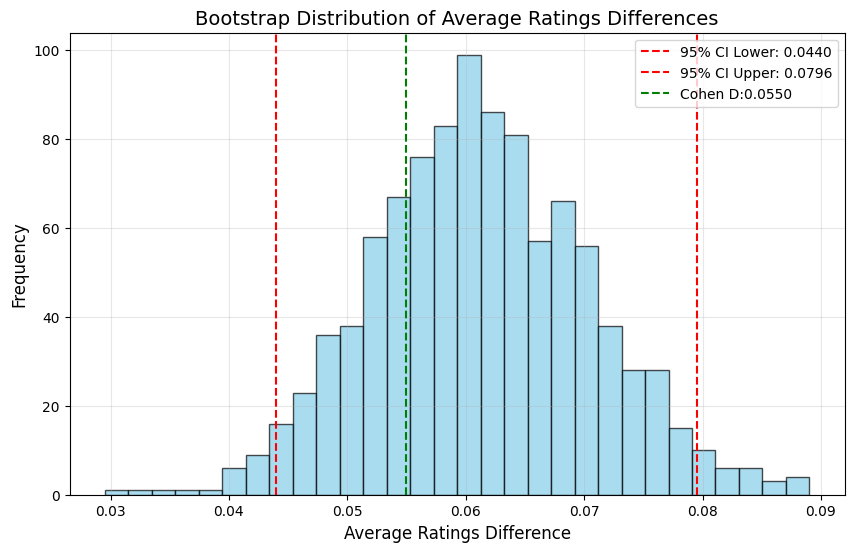

In [ ]:
# visualization: avg mean
# define 95% confidence interval
np.random.seed(seed)
n_bootstraps = 1000
bootstrap_mean_diffs = []
d = cohen_d(male_avg_rating.dropna(),female_avg_rating.dropna())
for _ in range(n_bootstraps):
    male_sample = np.random.choice(male_avg_rating.dropna(), len(male_avg_rating.dropna()), replace=True)
    female_sample = np.random.choice(female_avg_rating.dropna(), len(female_avg_rating.dropna()), replace=True)
    bootstrap_mean_diffs.append(np.mean(male_sample) - np.mean(female_sample))

# 95% confidence interval
confidence_interval_mean = (
    np.percentile(bootstrap_mean_diffs, 2.5),
    np.percentile(bootstrap_mean_diffs, 97.5),
)

# Visualize the bootstrap variance differences as a histogram
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_mean_diffs, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=confidence_interval_mean[0], color='red', linestyle='--', label=f"95% CI Lower: {confidence_interval_mean[0]:.4f}")
plt.axvline(x=confidence_interval_mean[1], color='red', linestyle='--', label=f"95% CI Upper: {confidence_interval_mean[1]:.4f}")
plt.axvline(x=d, color = 'green', linestyle='--', label=f'Cohen D:{d:.4f}' )
plt.title("Bootstrap Distribution of Average Ratings Differences", fontsize=14)
plt.xlabel("Average Ratings Difference", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()


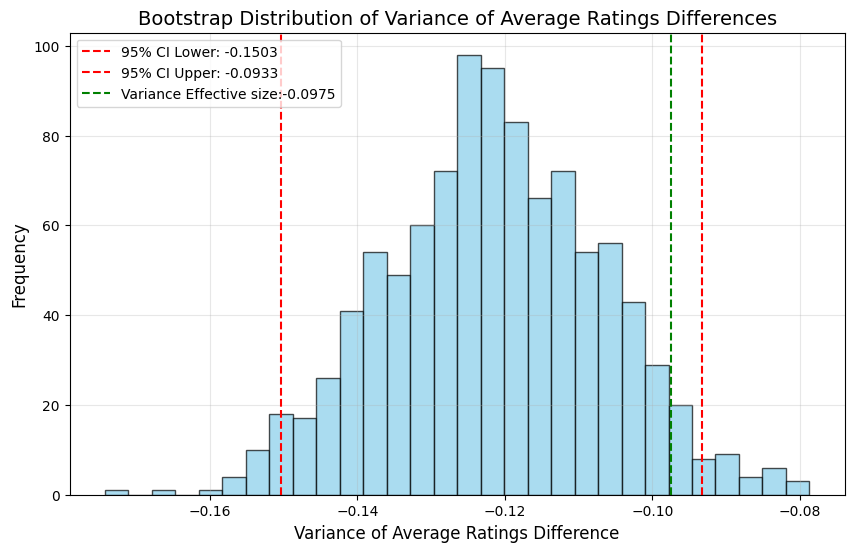

In [ ]:
# visualization: avg variance
bootstrap_var_diffs = []
var_size = var_diff(male_avg_rating.dropna(),female_avg_rating.dropna())
for _ in range(n_bootstraps):
    male_sample = np.random.choice(male_avg_rating.dropna(), len(male_avg_rating.dropna()), replace=True)
    female_sample = np.random.choice(female_avg_rating.dropna(), len(female_avg_rating.dropna()), replace=True)
    # sample variance with ddof = 1 (N-1)
    bootstrap_var_diffs.append(np.var(male_sample, ddof=1) - np.var(female_sample, ddof=1))

# 95% confidence interval
confidence_interval_variance = (
    np.percentile(bootstrap_var_diffs, 2.5),
    np.percentile(bootstrap_var_diffs, 97.5),
)

# Visualize the bootstrap variance differences as a histogram
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_var_diffs, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=confidence_interval_variance[0], color='red', linestyle='--', label=f"95% CI Lower: {confidence_interval_variance[0]:.4f}")
plt.axvline(x=confidence_interval_variance[1], color='red', linestyle='--', label=f"95% CI Upper: {confidence_interval_variance[1]:.4f}")
plt.axvline(x=var_size, color='green', linestyle='--', label=f'Variance Effective size:{var_size:.4f}')
plt.title("Bootstrap Distribution of Variance of Average Ratings Differences", fontsize=14)
plt.xlabel("Variance of Average Ratings Difference", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()


**Question 4: Is there a gender difference in the tags awarded by students? Make sure to teach each of the 20 tags
for a potential gender difference and report which of them exhibit a statistically significant different.
Comment on the 3 most gendered (lowest p-value) and least gendered (highest p-value) tags.**

In [ ]:
# combine dataset
combined_dataset = num[['Male Gender', 'Female Gender','Number of Ratings']].join(tags).dropna()
print(combined_dataset.shape)

# accept all the data
# divide into two groups: male and female professor
male_tags = combined_dataset[combined_dataset['Male Gender'] == 1].iloc[:, 3:]
female_tags = combined_dataset[combined_dataset['Female Gender'] == 1].iloc[:, 3:]
num_male_rating = combined_dataset[combined_dataset['Male Gender'] == 1]['Number of Ratings']
num_female_rating = combined_dataset[combined_dataset['Male Gender'] == 1]['Number of Ratings']
print(male_tags.shape)
print(female_tags.shape)

(70004, 23)
(29376, 20)
(27139, 20)


In [ ]:
# normalize the tags in male/female groups
def normalize(df1, df2):
    # df1, df2 having the same index of rows
    if isinstance(df2, pd.DataFrame):
        df2 = df2.iloc[:, 0]

    # Perform row-wise normalization
    normalized_df = df1.divide(df2, axis=0)

    return normalized_df

# after-normalized dataset
male_tags_norm = normalize(male_tags, num_male_rating)
female_tags_norm = normalize(female_tags, num_female_rating)

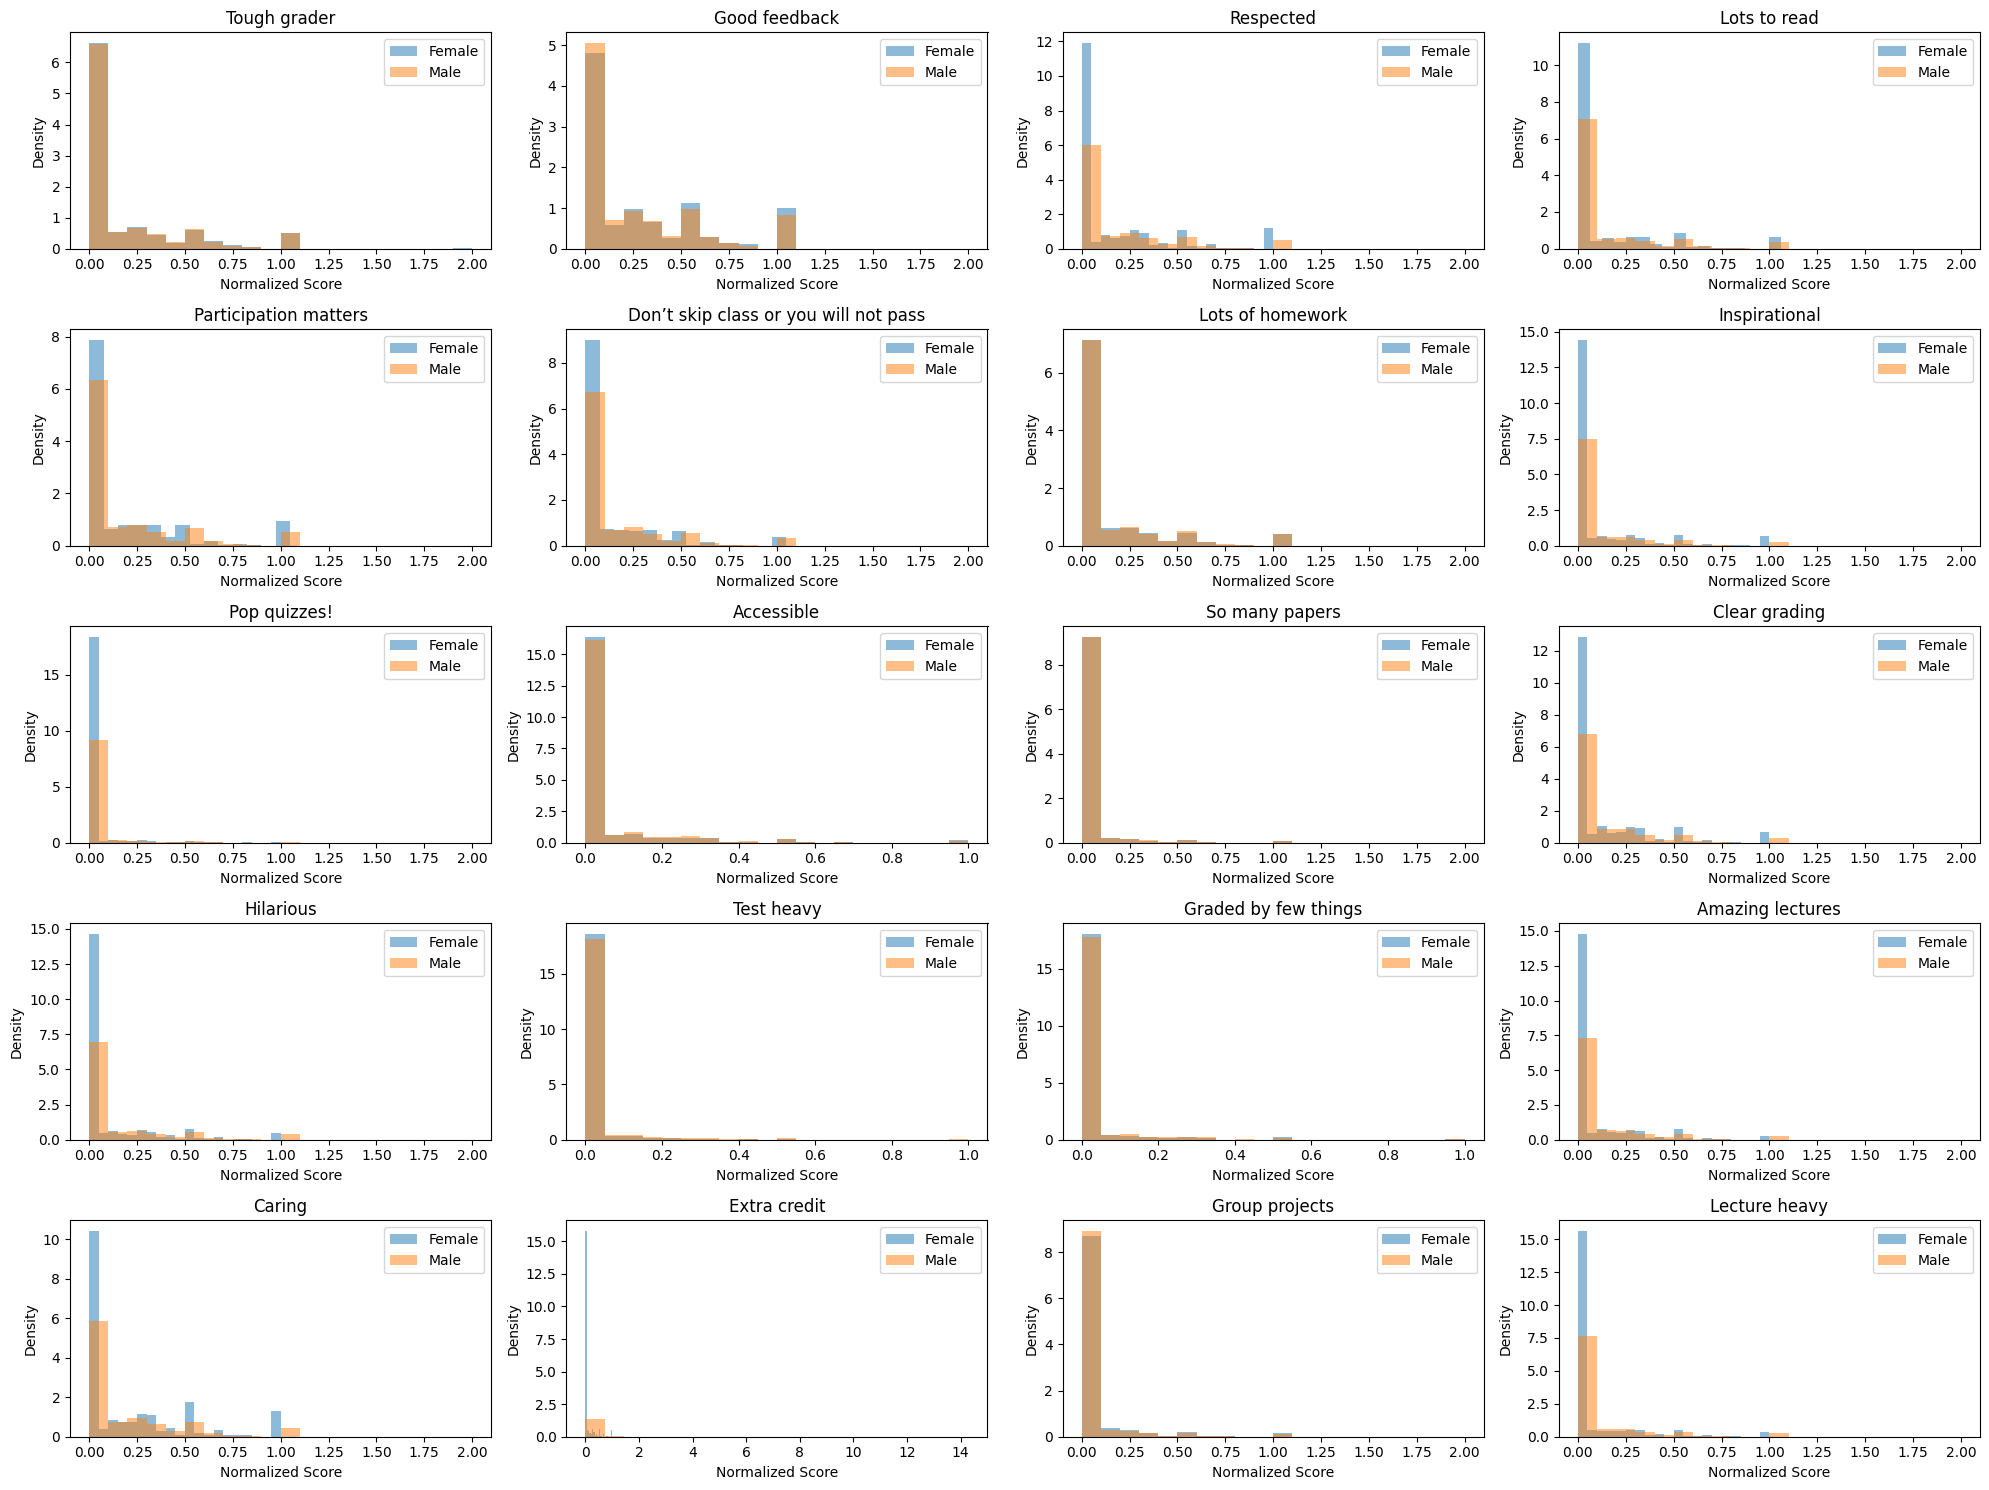

In [ ]:
# visualization for tags distribution in male/female by tag
# Drop missing values for both groups
female_data_cleaned = female_tags_norm.dropna()
male_data_cleaned = male_tags_norm.dropna()

# Plot distribution for each tag
tags_name = male_tags_norm.columns
plt.figure(figsize=(20, 15))

for i, tag in enumerate(tags_name, start=1):
    plt.subplot(5, 4, i)  # Create a grid of 5x4 for subplots
    plt.hist(female_data_cleaned[tag], bins=20, alpha=0.5, label='Female', density=True)
    plt.hist(male_data_cleaned[tag], bins=20, alpha=0.5, label='Male', density=True)
    plt.title(tag)
    plt.xlabel('Normalized Score')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# investigate gender difference between tags using normalized columns
results = []
for column in male_tags_norm.columns:
    stat, p_value = stats.mannwhitneyu(
        male_data_cleaned[column],
        female_data_cleaned[column],
    )
    results.append({"Tag": column, "stat": stat, "p-value": p_value})

# Convert results to DataFrame and sort by p-value
results_df = pd.DataFrame(results).sort_values(by="p-value")
results_df

,Tag,stat,p-value
12,Hilarious,34638734.0,5.799818e-10
16,Caring,30639060.0,6.888897e-07
19,Lecture heavy,34050326.0,1.514793e-06
13,Test heavy,33400451.0,2.228593e-05
15,Amazing lectures,33640529.5,6.480273e-04
18,Group projects,31697359.0,7.253843e-04
1,Good feedback,31243147.0,1.206206e-03
4,Participation matters,31437980.5,3.607658e-03
14,Graded by few things,33072246.5,1.450641e-02
8,Pop quizzes!,32885884.5,6.605959e-02


In [ ]:
print(results_df.head(3))
print(results_df.tail(3))

              Tag        stat       p-value
12      Hilarious  34638734.0  5.799818e-10
16         Caring  30639060.0  6.888897e-07
19  Lecture heavy  34050326.0  1.514793e-06
                 Tag        stat   p-value
10    So many papers  32381492.5  0.553735
6   Lots of homework  32701122.5  0.563733
7      Inspirational  32563330.5  0.858433


**Question 5: Is there a gender difference in terms of average difficulty? Again, a significance test is indicated.**

In [ ]:
# 1. accpect all the data
male_avg_diff = num[num['Male Gender'] == 1]['Average Difficulty']
female_avg_diff = num[num['Female Gender'] == 1]['Average Difficulty']

#check the size of groups
print(male_avg_diff.shape)
print(female_avg_diff.shape)

# conduct independent t-test
# null hypothesis: There is no difference between average expected difficulty between male and female professors assuming equal variance in the difficulties.
from scipy import stats
stat, p_val = stats.ttest_ind(male_avg_diff, female_avg_diff, nan_policy='omit',random_state= seed)
print(stat, p_val)

(29376,)
(27139,)
-0.5691012227662594 0.5692897103282564


In [ ]:
# 2. accpect data only exceeding to certain threshold
male_num_diff_median = num[num['Male Gender'] == 1]['Number of Ratings'].median()
female_num_diff_median = num[num['Female Gender'] == 1]['Number of Ratings'].median()

# check the median rating number for two groups
print(male_num_diff_median)
print(female_num_diff_median)

male_avg_diff_threshold = num[(num['Male Gender'] == 1) & (num['Number of Ratings'] >= male_num_diff_median)]['Average Difficulty']
female_avg_diff_threshold = num[(num['Female Gender'] == 1) & (num['Number of Ratings'] >= female_num_diff_median)]['Average Difficulty']


#check the size of groups
print(male_avg_diff_threshold.shape)
print(female_avg_diff_threshold.shape)

# conduct independent t-test
# null hypothesis: There is no difference between average expected difficulty between male and female professors assuming equal variance in the difficulties.
from scipy import stats
stat, p_val = stats.ttest_ind(male_avg_diff_threshold, female_avg_diff_threshold, nan_policy='omit',random_state= seed)
print(stat, p_val)

3.0
3.0
(17024,)
(15148,)
0.17685358447181396 0.8596245113789349


**Question 6: Please quantify the likely size of this effect at 95% confidence.**

In [ ]:
# use cohen's d for effective size computation
def cohen_d(group1, group2):
    mean1, mean2 = group1.mean(), group2.mean()
    std1, std2 = group1.std(), group2.std()
    n1, n2 = len(group1), len(group2)
    # Pooled standard deviation
    pooled_std = ((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2) # pooled std (different with previous question)
    pooled_std = pooled_std**0.5
    return (mean1 - mean2) / pooled_std

# Compute Cohen's d
effect_size = cohen_d(male_avg_diff,female_avg_diff)
print("Cohen's d (Effect Size):", effect_size)

Cohen's d (Effect Size): -0.004791573280039929


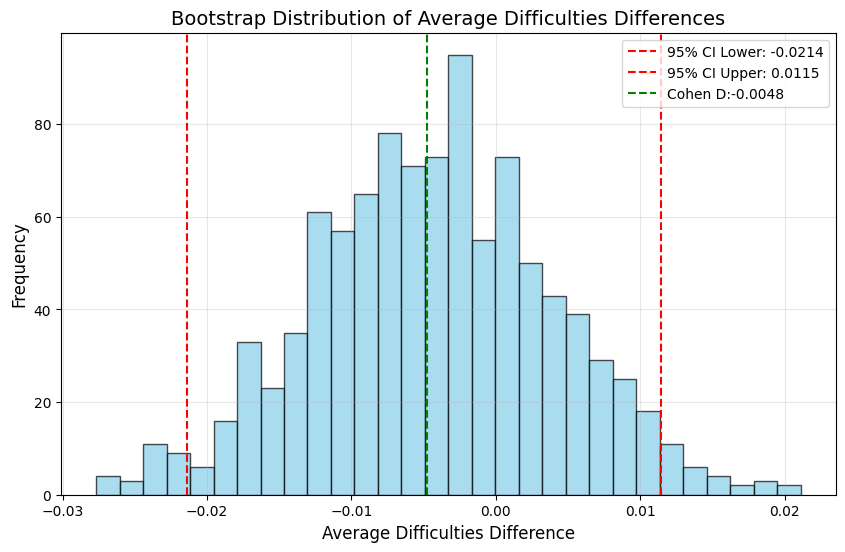

In [ ]:
# visualization
# define 95% confidence interval
np.random.seed(seed)
n_bootstraps = 1000
bootstrap_mean_diffs = []
for _ in range(n_bootstraps):
    male_sample = np.random.choice(male_avg_diff.dropna(), len(male_avg_diff.dropna()), replace=True)
    female_sample = np.random.choice(female_avg_diff.dropna(), len(female_avg_diff.dropna()), replace=True)
    bootstrap_mean_diffs.append(np.mean(male_sample) - np.mean(female_sample))

# 95% confidence interval
confidence_interval_mean = (
    np.percentile(bootstrap_mean_diffs, 2.5),
    np.percentile(bootstrap_mean_diffs, 97.5),
)

# Visualize the bootstrap variance differences as a histogram
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_mean_diffs, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=confidence_interval_mean[0], color='red', linestyle='--', label=f"95% CI Lower: {confidence_interval_mean[0]:.4f}")
plt.axvline(x=confidence_interval_mean[1], color='red', linestyle='--', label=f"95% CI Upper: {confidence_interval_mean[1]:.4f}")
plt.axvline(x=effect_size, color = 'green', linestyle='--', label=f'Cohen D:{effect_size:.4f}' )
plt.title("Bootstrap Distribution of Average Difficulties Differences", fontsize=14)
plt.xlabel("Average Difficulties Difference", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()


**Question 7: Build a regression model predicting average rating from all numerical predictors (the ones in the rmpCapstoneNum.csv) file. Make sure to include the R^2 and RMSE of this model. Which of these factors is most strongly predictive of average rating? Hint: Make sure to address collinearity concerns.**

In [ ]:
# import packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# Separate predictors and target
X = num.drop(columns=["Average Rating"])  # Predictors
y = num["Average Rating"]                 # Target

# Check for missing values and fill them with mean
X = X.fillna(X.mean())
y = y.fillna(y.mean())

In [ ]:
# Check collinearity
# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

# Drop highly collinear features (10 as threshold)
X = X.drop(columns=vif_data[vif_data["VIF"] > 10]["Feature"])

                       Feature        VIF
0           Average Difficulty   9.483024
1            Number of Ratings   1.685705
2              Received Pepper   1.644128
3  Take Class Again Proportion  11.892659
4         Online Ratings Count   1.153328
5                  Male Gender   1.673875
6                Female Gender   1.612699


In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

In [ ]:
# Calculate R-squared and RMSE
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R^2: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

R^2: 0.3505
RMSE: 0.8028


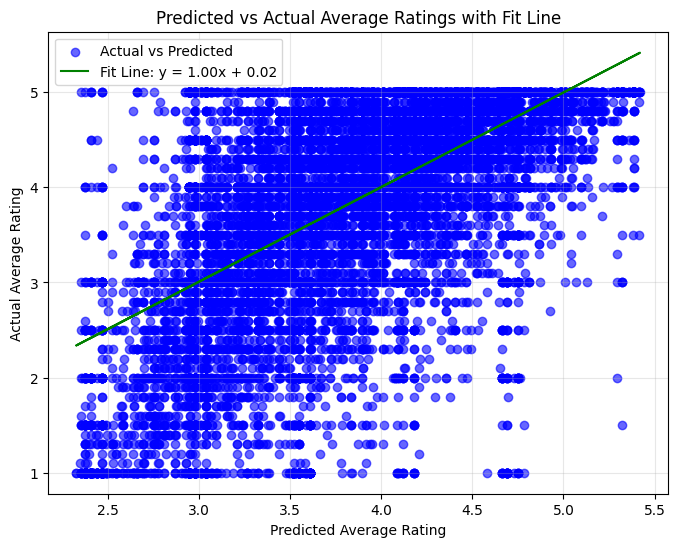

In [ ]:
# Fit a linear trendline
fit_coefficients = np.polyfit(y_pred, y_test, deg=1)
fit_line = np.poly1d(fit_coefficients)

# Scatter plot with trendline
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test, alpha=0.6, color="blue", label="Actual vs Predicted")
plt.plot(y_pred, fit_line(y_pred), color="green", label=f"Fit Line: y = {fit_coefficients[0]:.2f}x + {fit_coefficients[1]:.2f}")

# Add labels, title, and legend
plt.xlabel("Predicted Average Rating")
plt.ylabel("Actual Average Rating")
plt.title("Predicted vs Actual Average Ratings with Fit Line")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Extract feature coefficients
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

print(coefficients)

# Identify the most predictive factor
most_predictive = coefficients.iloc[0]
print(f"The most predictive factor is {most_predictive['Feature']} with a coefficient of {most_predictive['Coefficient']:.4f}.")

                Feature  Coefficient
2       Received Pepper     0.631615
0    Average Difficulty    -0.571567
4           Male Gender     0.091581
5         Female Gender     0.031027
3  Online Ratings Count    -0.023802
1     Number of Ratings     0.000869
The most predictive factor is Received Pepper with a coefficient of 0.6316.


**Question 8: Build a regression model predicting average ratings from all tags (the ones in the rmpCapstoneTags.csv) file. Make sure to include the R^2 and RMSE of this model. Which of these tags is most strongly predictive of average rating? Hint: Make sure to address collinearity concerns. Also comment on how this model compares to the previous one.**

In [ ]:
# Separate predictors and target
X_2 = tags  # Predictors
y_2 = num["Average Rating"]   # Target

# Check for missing values and fill them with mean
X_2 = X_2.fillna(X_2.mean())
y_2 = y_2.fillna(y_2.mean())

In [ ]:
# Check collinearity
# Calculate VIF for each predictor
vif_data_2 = pd.DataFrame()
vif_data_2["Feature"] = X_2.columns
vif_data_2["VIF"] = [variance_inflation_factor(X_2.values, i) for i in range(X_2.shape[1])]
print(vif_data_2)

# Drop highly collinear features (10 as threshold)
X_2 = X_2.drop(columns=vif_data_2[vif_data_2["VIF"] > 10]["Feature"])

                                  Feature       VIF
0                            Tough grader  2.528223
1                           Good feedback  3.407101
2                               Respected  4.038748
3                            Lots to read  1.797317
4                   Participation matters  2.199905
5   Don’t skip class or you will not pass  2.544241
6                        Lots of homework  1.906057
7                           Inspirational  2.963519
8                            Pop quizzes!  1.207973
9                              Accessible  1.881011
10                         So many papers  1.258024
11                          Clear grading  2.358959
12                              Hilarious  2.069158
13                             Test heavy  1.738232
14                   Graded by few things  1.422271
15                       Amazing lectures  3.015469
16                                 Caring  3.653912
17                           Extra credit  1.573000
18          

In [ ]:
# Split the data into training and test sets
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.2, random_state=seed)

# Fit a linear regression model
model_2 = LinearRegression()
model_2.fit(X_2_train, y_2_train)

# Make predictions on the test set
y_2_pred = model_2.predict(X_2_test)

In [ ]:
# Calculate R-squared and RMSE
r2_2 = r2_score(y_2_test, y_2_pred)
rmse_2 = np.sqrt(mean_squared_error(y_2_test, y_2_pred))

print(f"R^2: {r2_2:.4f}")
print(f"RMSE: {rmse_2:.4f}")

R^2: 0.1523
RMSE: 0.9172


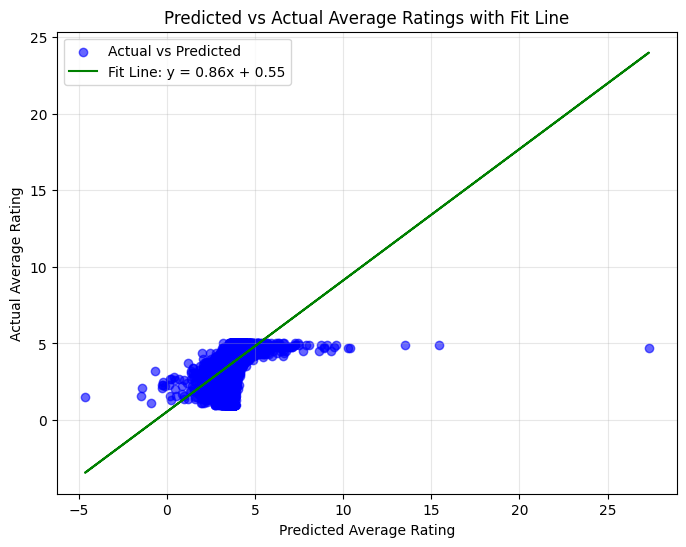

In [ ]:
# Fit a linear trendline
fit_coefficients_2 = np.polyfit(y_2_pred, y_2_test, deg=1)
fit_line_2 = np.poly1d(fit_coefficients_2)

# Scatter plot with trendline
plt.figure(figsize=(8, 6))
plt.scatter(y_2_pred, y_2_test, alpha=0.6, color="blue", label="Actual vs Predicted")
plt.plot(y_2_pred, fit_line_2(y_2_pred), color="green", label=f"Fit Line: y = {fit_coefficients_2[0]:.2f}x + {fit_coefficients_2[1]:.2f}")

# Add labels, title, and legend
plt.xlabel("Predicted Average Rating")
plt.ylabel("Actual Average Rating")
plt.title("Predicted vs Actual Average Ratings with Fit Line")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Extract feature coefficients
coefficients_2 = pd.DataFrame({
    "Feature": X_2.columns,
    "Coefficient": model_2.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

print(coefficients_2)

# Identify the most predictive factor
most_predictive_2 = coefficients_2.iloc[0]
print(f"The most predictive factor is {most_predictive_2['Feature']} with a coefficient of {most_predictive_2['Coefficient']:.4f}.")

                                  Feature  Coefficient
0                            Tough grader    -0.127724
10                         So many papers    -0.124299
14                   Graded by few things    -0.090740
19                          Lecture heavy    -0.081027
18                         Group projects    -0.063282
1                           Good feedback     0.062871
16                                 Caring     0.058450
15                       Amazing lectures     0.047885
11                          Clear grading     0.037483
13                             Test heavy     0.034646
6                        Lots of homework    -0.027911
9                              Accessible    -0.026390
2                               Respected     0.022120
8                            Pop quizzes!     0.018042
12                              Hilarious     0.010684
7                           Inspirational    -0.008965
17                           Extra credit    -0.006530
5   Don’t 

**Question 9: Build a regression model predicting average difficulty from all tags (the ones in the
rmpCapstoneTags.csv) file. Make sure to include the R2 and RMSE of this model. Which of these tags is
most strongly predictive of average difficulty? Hint: Make sure to address collinearity concerns.**

In [ ]:
# Separate predictors (tags) and target (Average Difficulty)
X_3 = tags  # predictors
y_3 = num["Average Difficulty"]  # target

# Handle missing values
X_3 = X_3.fillna(X_3.mean())
y_3 = y_3.fillna(y_3.mean())

In [ ]:
# Check collinearity with Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_3.columns
vif_data["VIF"] = [variance_inflation_factor(X_3.values, i) for i in range(X_3.shape[1])]
print(vif_data)

X_3 = X_3.drop(columns=vif_data[vif_data["VIF"] > 10]["Feature"])  # Drop highly collinear features

                                  Feature       VIF
0                            Tough grader  2.528223
1                           Good feedback  3.407101
2                               Respected  4.038748
3                            Lots to read  1.797317
4                   Participation matters  2.199905
5   Don’t skip class or you will not pass  2.544241
6                        Lots of homework  1.906057
7                           Inspirational  2.963519
8                            Pop quizzes!  1.207973
9                              Accessible  1.881011
10                         So many papers  1.258024
11                          Clear grading  2.358959
12                              Hilarious  2.069158
13                             Test heavy  1.738232
14                   Graded by few things  1.422271
15                       Amazing lectures  3.015469
16                                 Caring  3.653912
17                           Extra credit  1.573000
18          

In [ ]:
# Split the data
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, test_size=0.2, random_state=seed)

# Fit the regression model
model_3 = LinearRegression()
model_3.fit(X_3_train, y_3_train)

# Predict
y_3_pred = model_3.predict(X_3_test)

# Calculate R-squared and RMSE
r2_3 = r2_score(y_3_test, y_3_pred)
rmse_3 = mean_squared_error(y_3_test, y_3_pred)

print(f"R^2: {r2_3:.4f}")
print(f"RMSE: {rmse_3:.4f}")


R^2: 0.1451
RMSE: 0.6584


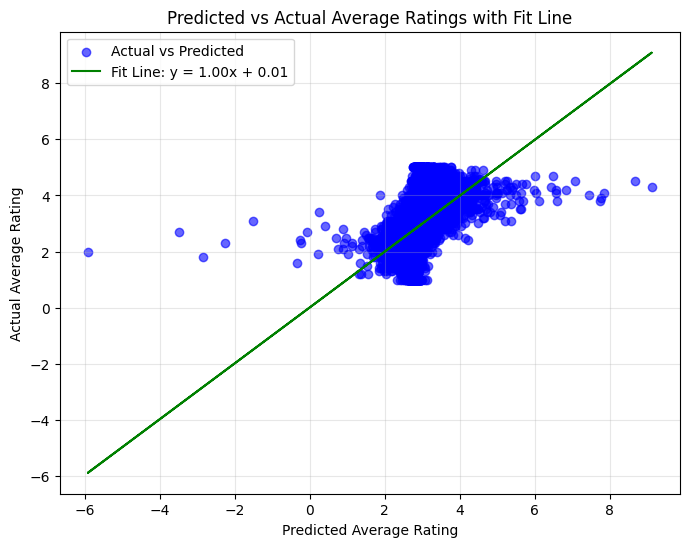

In [ ]:
# Fit a linear trendline
fit_coefficients_3 = np.polyfit(y_3_pred, y_3_test, deg=1)
fit_line_3 = np.poly1d(fit_coefficients_3)

# Scatter plot with trendline
plt.figure(figsize=(8, 6))
plt.scatter(y_3_pred, y_3_test, alpha=0.6, color="blue", label="Actual vs Predicted")
plt.plot(y_3_pred, fit_line_3(y_3_pred), color="green", label=f"Fit Line: y = {fit_coefficients_3[0]:.2f}x + {fit_coefficients_3[1]:.2f}")

# Add labels, title, and legend
plt.xlabel("Predicted Average Rating")
plt.ylabel("Actual Average Rating")
plt.title("Predicted vs Actual Average Ratings with Fit Line")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Identify most predictive tags
coefficients_3 = pd.DataFrame({
    "Feature": X_3.columns,
    "Coefficient": model_3.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

print(coefficients_3)

# Identify the most predictive factor
most_predictive_3 = coefficients_3.iloc[0]
print(f"The most predictive factor is {most_predictive_3['Feature']} with a coefficient of {most_predictive_3['Coefficient']:.4f}.")

                                  Feature  Coefficient
0                            Tough grader     0.144050
9                              Accessible     0.083493
11                          Clear grading    -0.057834
14                   Graded by few things    -0.046639
16                                 Caring    -0.046057
10                         So many papers     0.043895
8                            Pop quizzes!    -0.037424
12                              Hilarious    -0.024734
5   Don’t skip class or you will not pass     0.021026
17                           Extra credit    -0.015897
4                   Participation matters    -0.013336
3                            Lots to read     0.012746
7                           Inspirational    -0.010690
15                       Amazing lectures     0.009839
1                           Good feedback    -0.008363
6                        Lots of homework     0.006081
19                          Lecture heavy     0.003533
18        

**Question 10: Build a classification model that predicts whether a professor receives a “pepper” from all available
factors (both tags and numerical). Make sure to include model quality metrics such as AU(RO)C and
also address class imbalance concerns.**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE

In [ ]:
# Combine numerical and tag data
X_4 = pd.concat([num.drop(columns=["Received Pepper"]), tags], axis=1)
y_4 = num["Received Pepper"]

# Handle missing values
X_4 = X_4.fillna(X_4.mean())
y_4 = y_4.fillna(0)

# Address class imbalance using SMOTE
smote = SMOTE(random_state=seed)
X_4_resampled, y_4_resampled = smote.fit_resample(X_4, y_4)

In [ ]:
# Split the data
X_4_train, X_4_test, y_4_train, y_4_test = train_test_split(X_4_resampled, y_4_resampled, test_size=0.2, random_state=seed)

# Fit a Random Forest Classifier
clf = RandomForestClassifier(random_state=seed)
clf.fit(X_4_train, y_4_train)

# Predict and evaluate
y_4_pred = clf.predict(X_4_test)
y_4_proba = clf.predict_proba(X_4_test)[:, 1]

# Metrics
auc = roc_auc_score(y_4_test, y_4_proba)

print(f"AUCROC: {auc:.4f}")
print(classification_report(y_4_test, y_4_pred))

AUCROC: 0.9476
              precision    recall  f1-score   support

         0.0       0.90      0.84      0.87     14180
         1.0       0.84      0.90      0.87     13939

    accuracy                           0.87     28119
   macro avg       0.87      0.87      0.87     28119
weighted avg       0.87      0.87      0.87     28119



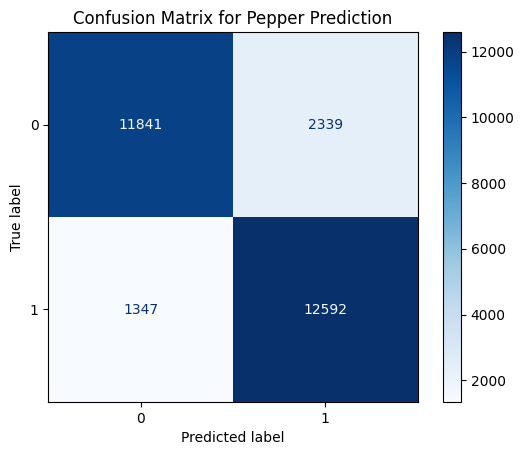

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(y_4_test, y_4_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix for Pepper Prediction")
plt.show()


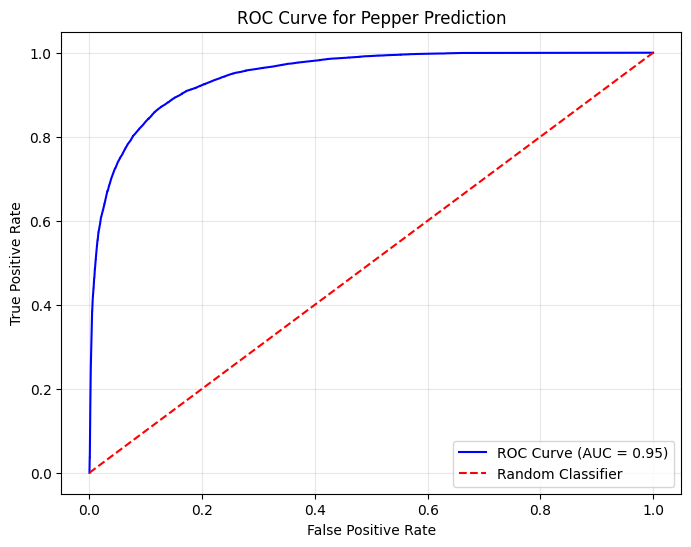

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_4_test, y_4_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="red", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Pepper Prediction")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


**Extra credit: Tell us something interesting about this dataset that is not trivial and not already part of
an answer (implied or explicitly) to these enumerated questions [Suggestion: Do something with the
qualitative data, e.g. major, university or state by linking the qualitative data to the two other data files
(tags and numerical)].**


For extra credit, we choose to analyze states' differences in professor ratings (average rating, difficulty) and identify statistically significant differences.




In [ ]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Keep only Average Rating and Average Difficulty from the num dataset
num_copy = num.copy()
num_copy = num_copy[["Average Rating", "Average Difficulty"]]

# Combine the qualitative data (fields, universities, states) with numerical data
combined_data = pd.concat([qual, num_copy], axis=1)

# Replace missing values for Average Rating and Average Difficulty with their column means
combined_data["Average Rating"] = combined_data["Average Rating"].fillna(combined_data["Average Rating"].mean())
combined_data["Average Difficulty"] = combined_data["Average Difficulty"].fillna(combined_data["Average Difficulty"].mean())

# Filter valid two-character US states
combined_data = combined_data[combined_data["US State"].str.len() == 2]

# Ensure all columns are aligned correctly
combined_data.reset_index(drop=True, inplace=True)

# Display the combined data to verify
print(combined_data.head())

      Major / Field                     University US State  Average Rating  \
0  Criminal Justice        George Mason University       VA             5.0   
1           English       Alabama State University       AL             3.2   
2           English         University of Kentucky       KY             3.6   
3           English              Keiser University       FL             1.0   
4           English  Eastern Florida State College       FL             3.5   

   Average Difficulty  
0                 1.5  
1                 3.0  
2                 3.5  
3                 5.0  
4                 3.3  


<ipython-input-144-5970f93f01af>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_means_sorted_rating, x="US State", y="Average Rating", palette="coolwarm")


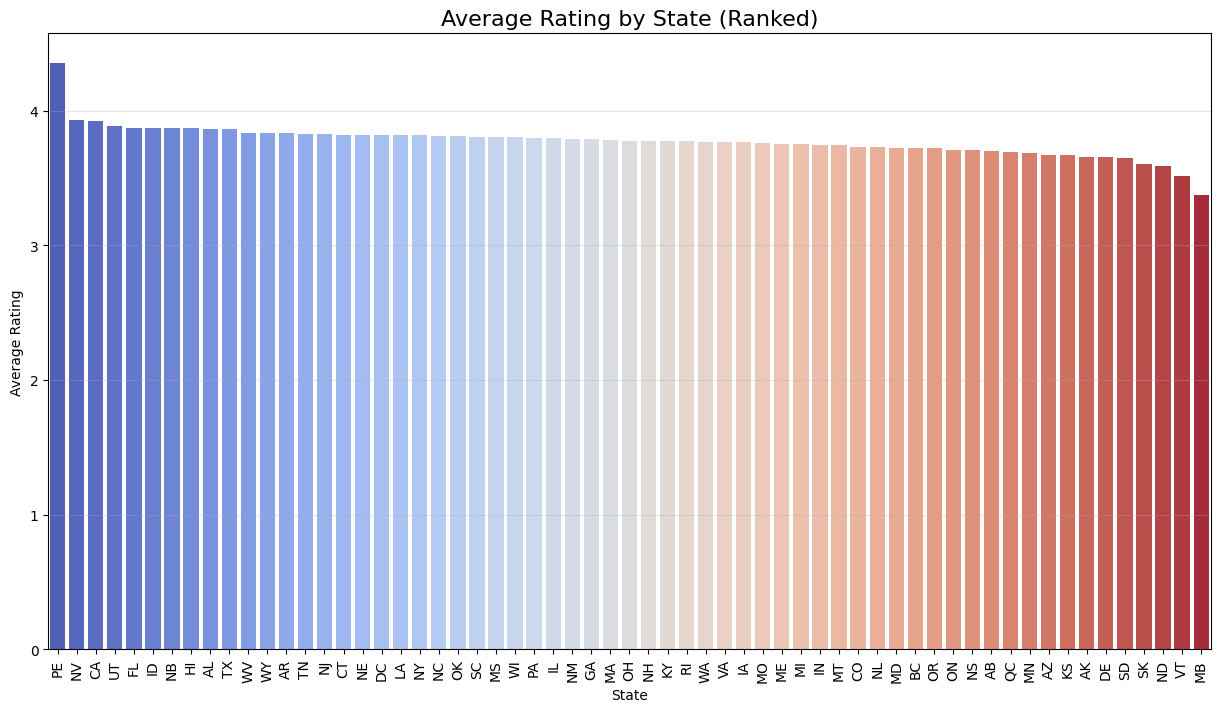

<ipython-input-144-5970f93f01af>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_means_sorted_difficulty, x="US State", y="Average Difficulty", palette="viridis")


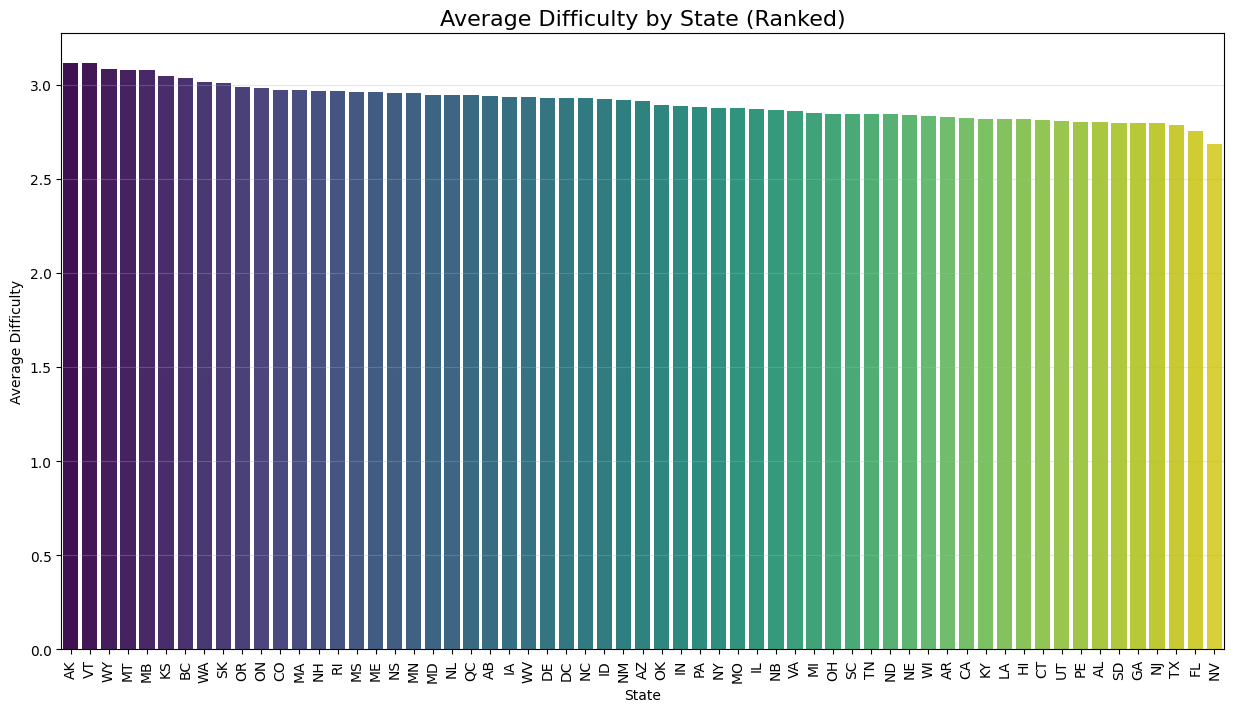

In [ ]:
# Calculate mean scores for each state
state_means = combined_data.groupby("US State").agg({
    "Average Rating": "mean",
    "Average Difficulty": "mean"
}).reset_index()

# Sort states by average rating
state_means_sorted_rating = state_means.sort_values(by="Average Rating", ascending=False)

# Plot for Average Rating by State
plt.figure(figsize=(15, 8))
sns.barplot(data=state_means_sorted_rating, x="US State", y="Average Rating", palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Average Rating by State (Ranked)", fontsize=16)
plt.xlabel("State")
plt.ylabel("Average Rating")
plt.grid(axis="y", alpha=0.3)
plt.show()

# Sort states by average difficulty
state_means_sorted_difficulty = state_means.sort_values(by="Average Difficulty", ascending=False)

# Plot for Average Difficulty by State
plt.figure(figsize=(15, 8))
sns.barplot(data=state_means_sorted_difficulty, x="US State", y="Average Difficulty", palette="viridis")
plt.xticks(rotation=90)
plt.title("Average Difficulty by State (Ranked)", fontsize=16)
plt.xlabel("State")
plt.ylabel("Average Difficulty")
plt.grid(axis="y", alpha=0.3)
plt.show()

In [ ]:
# Group data by state for summary statistics
state_summary = combined_data.groupby("US State").agg({
    "Average Rating": ["mean", "std", "count"],
    "Average Difficulty": ["mean", "std", "count"]
}).reset_index()

# Display summary statistics
state_summary.columns = ["US State", "Rating Mean", "Rating Std", "Rating Count",
                         "Difficulty Mean", "Difficulty Std", "Difficulty Count"]

print(state_summary)

# Prepare data for ANOVA
ratings_by_state = [combined_data[combined_data["US State"] == state]["Average Rating"].dropna()
                    for state in combined_data["US State"].unique()]
difficulty_by_state = [combined_data[combined_data["US State"] == state]["Average Difficulty"].dropna()
                       for state in combined_data["US State"].unique()]

# Perform ANOVA for Average Rating
stat_rating, p_rating = f_oneway(*ratings_by_state)
print(f"ANOVA for Average Rating by State: F-statistic = {stat_rating:.4f}, p-value = {p_rating:.4f}")

# Perform ANOVA for Average Difficulty
stat_difficulty, p_difficulty = f_oneway(*difficulty_by_state)
print(f"ANOVA for Average Difficulty by State: F-statistic = {stat_difficulty:.4f}, p-value = {p_difficulty:.4f}")

# Post-hoc analysis (Tukey's HSD)
# Prepare data for Tukey's HSD
combined_data["Average Rating"] = combined_data["Average Rating"].dropna()
combined_data["Average Difficulty"] = combined_data["Average Difficulty"].dropna()

# Tukey HSD for Average Rating
tukey_rating = pairwise_tukeyhsd(endog=combined_data["Average Rating"],
                                 groups=combined_data["US State"],
                                 alpha=0.05)
print("\nTukey HSD Test for Average Rating by State:")
print(tukey_rating.summary())

# Tukey HSD for Average Difficulty
tukey_difficulty = pairwise_tukeyhsd(endog=combined_data["Average Difficulty"],
                                     groups=combined_data["US State"],
                                     alpha=0.05)
print("\nTukey HSD Test for Average Difficulty by State:")
print(tukey_difficulty.summary())


   US State  Rating Mean  Rating Std  Rating Count  Difficulty Mean  \
0        AB     3.700708    1.104841           565         2.941770   
1        AK     3.657292    1.194086            96         3.115625   
2        AL     3.862905    1.066814          1019         2.799902   
3        AR     3.830426    1.100108           516         2.830426   
4        AZ     3.672266    1.215392          1911         2.910937   
..      ...          ...         ...           ...              ...   
56       VT     3.516495    1.351364            97         3.114433   
57       WA     3.769722    1.107972          1189         3.013457   
58       WI     3.802357    1.083046           976         2.832172   
59       WV     3.833060    1.150545           366         2.932514   
60       WY     3.830435    1.318395            46         3.080435   

    Difficulty Std  Difficulty Count  
0         0.895689               565  
1         0.931476                96  
2         1.014439            

<ipython-input-146-19e2f3dd6e21>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_means_sorted_rating, x="US State", y="Average Rating", palette="coolwarm")


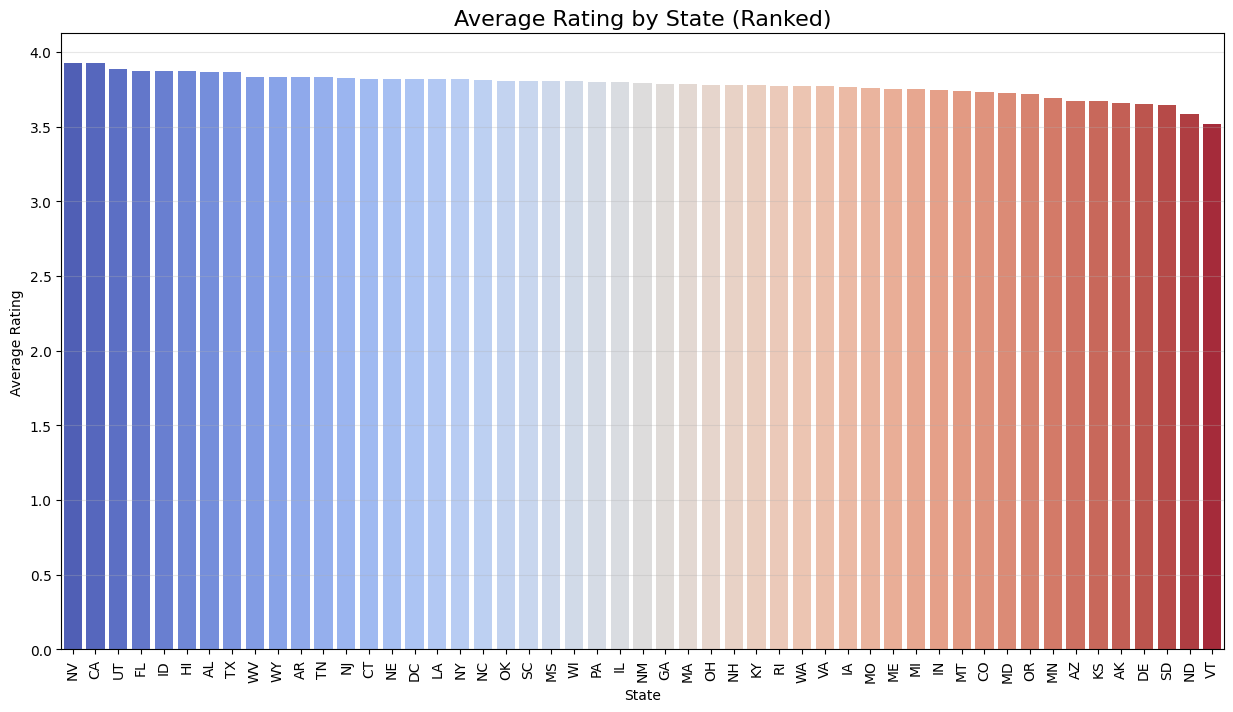

<ipython-input-146-19e2f3dd6e21>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_means_sorted_difficulty, x="US State", y="Average Difficulty", palette="viridis")


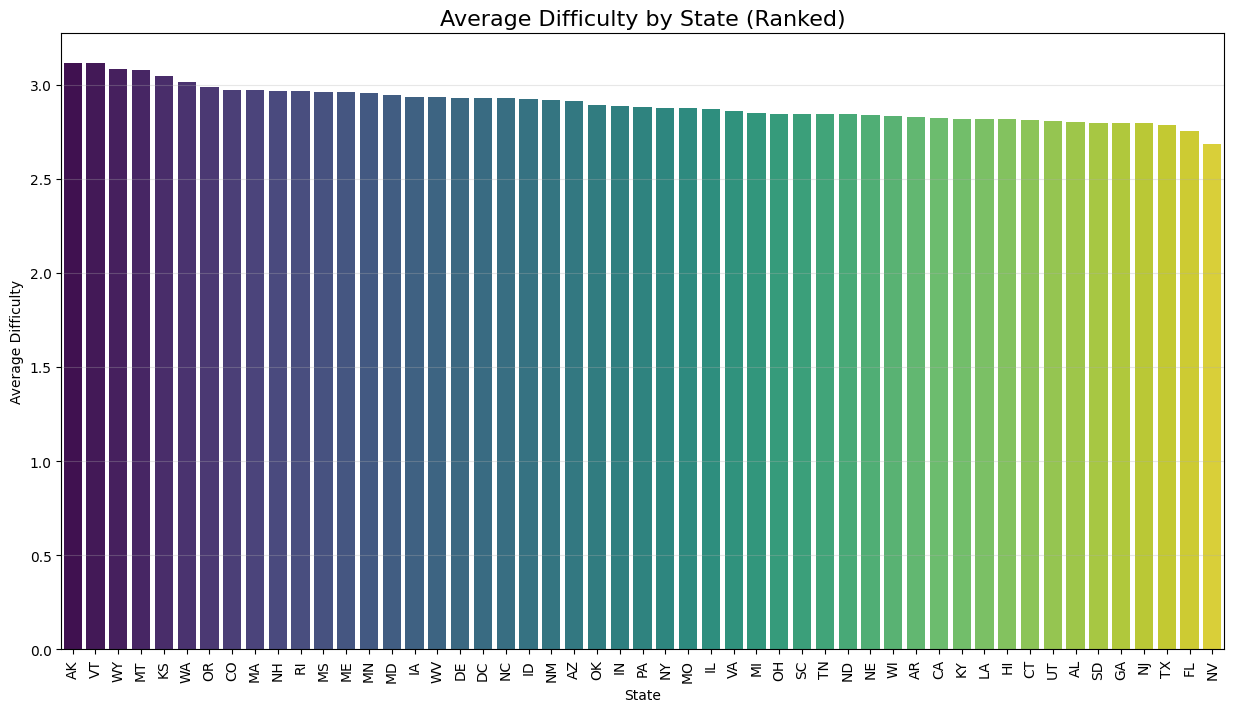

In [ ]:
# List of valid state abbreviations
valid_states = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "DC", "FL", "GA", "GU", "HI", "ID", "IL",
    "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV",
    "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "PR", "RI", "SC", "SD", "TN",
    "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]

# Filter the dataset to include only rows with valid state abbreviations
combined_data = combined_data[combined_data["US State"].isin(valid_states)]

# Calculate mean scores for each state
state_means = combined_data.groupby("US State").agg({
    "Average Rating": "mean",
    "Average Difficulty": "mean"
}).reset_index()

# Sort states by average rating
state_means_sorted_rating = state_means.sort_values(by="Average Rating", ascending=False)

# Plot for Average Rating by State
plt.figure(figsize=(15, 8))
sns.barplot(data=state_means_sorted_rating, x="US State", y="Average Rating", palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Average Rating by State (Ranked)", fontsize=16)
plt.xlabel("State")
plt.ylabel("Average Rating")
plt.grid(axis="y", alpha=0.3)
plt.show()

# Sort states by average difficulty
state_means_sorted_difficulty = state_means.sort_values(by="Average Difficulty", ascending=False)

# Plot for Average Difficulty by State
plt.figure(figsize=(15, 8))
sns.barplot(data=state_means_sorted_difficulty, x="US State", y="Average Difficulty", palette="viridis")
plt.xticks(rotation=90)
plt.title("Average Difficulty by State (Ranked)", fontsize=16)
plt.xlabel("State")
plt.ylabel("Average Difficulty")
plt.grid(axis="y", alpha=0.3)
plt.show()